In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(20)
from utils import roi_utils, default_paths, stats_utils

In [3]:
# Load results of the fitting procedure

subject = 8
volume_space=True

fitting_type = 'gabor_solo_ridge_12ori_8sf_plus_sketch_tokens'

out = load_fits.load_fit_results(subject, fitting_type, n_from_end=0, verbose=True);
# load_fits.print_output_summary(out)
fig_save_folder=None
roi_def = roi_utils.nsd_roi_def(subject) 
skip_inds = [10,11,15,23]


loading from /user_data/mmhender/imStat/model_fits/S08/gabor_solo_ridge_12ori_8sf_plus_sketch_tokens/Feb-16-2022_2245_48/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'voxel_subset_is_done_trn', 'voxel_subset_is_done_val', 'use_pca_st_feats', 'n_ori_gabor', 'n_sf_gabor', 'gabor_nonlin_fn'])


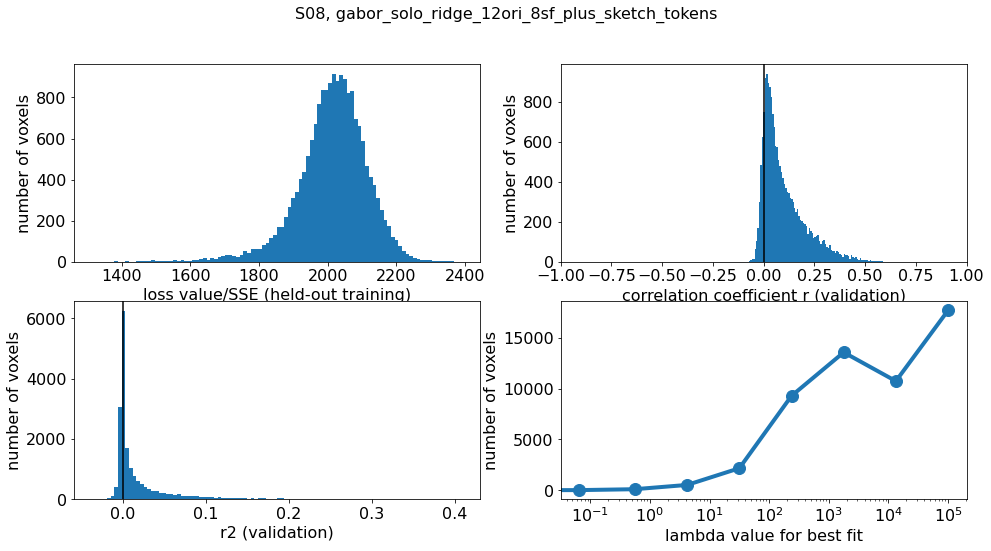

In [6]:
summary_plots.plot_perf_summary(fitting_type, out)

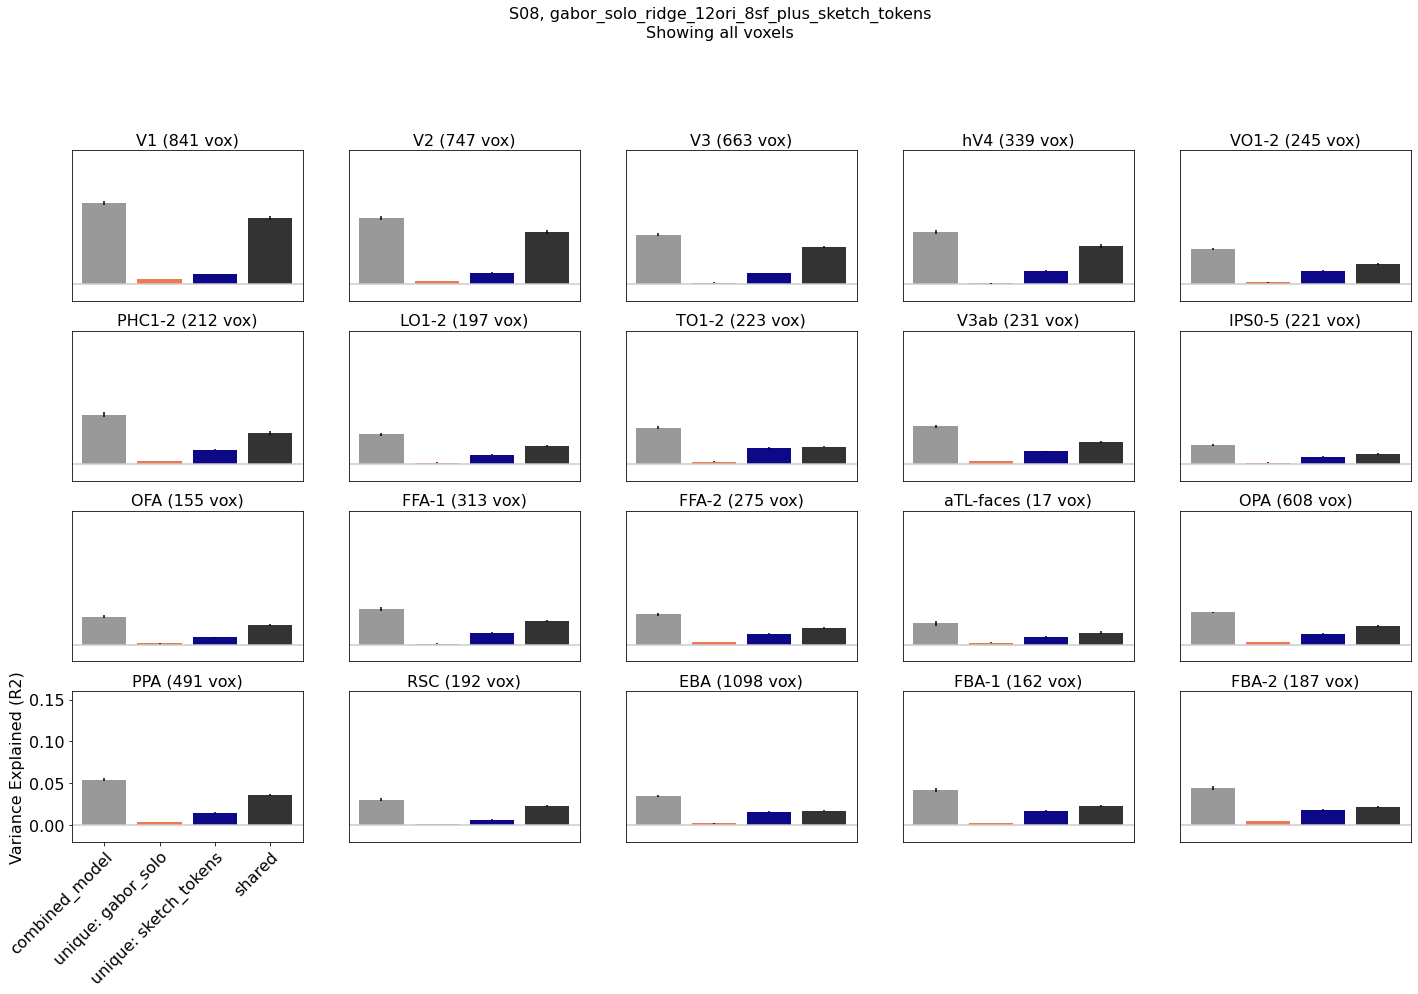

In [5]:
pp0 = 0
pp1 = 1
pp2 = 2
plot_utils.set_all_font_sizes(fs = 16)

val_r2 = out['val_r2']

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]

ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.02, 0.16])
plot_utils.create_roi_subplots(var_expl, inds2use, bp,roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)
